In [247]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from geopy.distance import great_circle
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import os
import mplleaflet
from itertools import chain
import seaborn as sns
import statsmodels

In [2]:
crimes = pd.DataFrame()

mypath = './metropolitan_all'
for (dirpath, dirnames, filenames) in os.walk(mypath):
    if dirpath is not './metropolitan_all':
        for filename in filenames:
            if 'csv' in filename and '2015' in filename:
                frame = pd.read_csv(dirpath + '/' + filename)
                crimes = crimes.append(frame, ignore_index=True)

len(crimes)

631378

In [3]:
crimes = crimes.dropna(axis=0, subset=['LSOA code'])
len(crimes)

623327

In [4]:
crimes = crimes[['Month','LSOA code',"Longitude","Latitude",'Crime type']]
all_crimes = crimes
len(all_crimes)

623327

In [6]:
lsoas = gpd.GeoDataFrame().from_file('./LSOA/LSOA_2011_EW_BGC_V2.shp')
lsoas = lsoas.to_crs(epsg=4326)
london_bounds = prep(Polygon([(-0.5, 51.3), (-0.5, 51.7), (0.3, 51.7), (0.3, 51.3)]))
lsoas_london = [lsoa for index, lsoa in lsoas.iterrows() if london_bounds.contains(lsoa.geometry)]
lsoas_london = gpd.GeoDataFrame(lsoas_london)
lsoas_london = lsoas_london.dropna(subset=['LSOA11CD'])
len(lsoas_london)

5331

In [7]:
crime_types = list(crimes['Crime type'].drop_duplicates())

In [8]:
list(enumerate(crime_types))

[(0, 'Bicycle theft'),
 (1, 'Burglary'),
 (2, 'Other theft'),
 (3, 'Theft from the person'),
 (4, 'Anti-social behaviour'),
 (5, 'Public order'),
 (6, 'Shoplifting'),
 (7, 'Other crime'),
 (8, 'Drugs'),
 (9, 'Vehicle crime'),
 (10, 'Violence and sexual offences'),
 (11, 'Criminal damage and arson'),
 (12, 'Possession of weapons'),
 (13, 'Robbery')]

In [9]:
points = [[row['Longitude'], row['Latitude']] for index, row in all_crimes[['Longitude', 'Latitude']].drop_duplicates().iterrows()]
points = [x for x in points if -0.5 < x[0] < 0.5 and 51.2 < x[1] < 51.7]

In [10]:
romford = [51.5750992,0.1763523]

In [11]:
locations = all_crimes[["LSOA code","Longitude","Latitude"]]
locations = locations.drop_duplicates()
locations = locations.reset_index(drop=1)
len(locations)

56447

In [162]:
distance_from_romford = pd.Series([great_circle(romford, [row['Latitude'], row['Longitude']]).km for index, row in locations.iterrows()])

In [13]:
locations = pd.concat([locations, distance_from_romford], axis=1)

In [159]:
locations.columns = ['LSOA', 'Longitude', 'Latitude', 'Dist']

In [160]:
locations = locations.sort_values(['Dist']).reset_index().drop('index', axis=1)

In [161]:
locations.head(2)

,LSOA,Longitude,Latitude,Dist
0,E01002356,0.176273,51.574669,0.048163
1,E01002356,0.176343,51.574317,0.087004


In [163]:
crimes.head(2)

,Month,LSOA code,Longitude,Latitude,Crime type
0,2015-01,E01000916,-0.106453,51.518207,Bicycle theft
1,2015-01,E01000914,-0.111497,51.518226,Burglary


In [125]:
crime_counts = dict()
for row_number, val in crimes.iterrows():
    key = (
            val['Longitude'],
            val['Latitude'],
            val['Crime type']
        )

    if crime_counts.has_key(key):
        crime_counts[key] = crime_counts[key] + 1
    else:
        crime_counts[key] = 1

In [132]:
crimes_count = crimes.groupby(['Longitude', 'Latitude', 'Crime type']).size().reset_index().rename(columns={0:'count'})

In [182]:
def get_crime_count(lon, lat=None, crime_type_temp = None):
    if crime_type_temp == None and lat == None:
        return crimes_count[crimes_count['Longitude'] == lon]['count'].sum()
    elif crime_type_temp == None:
        return crimes_count[crimes_count['Longitude'] == lon][crimes_count['Latitude'] == lat]['count'].sum()
    elif lat == None:
        return crimes_count[crimes_count['Longitude'] == lon][crimes_count['Crime type'] == crime_type_temp]['count'].sum()
    else:
        return crimes_count[crimes_count['Longitude'] == lon][crimes_count['Latitude'] == lat][crimes_count['Crime type'] == crime_type_temp]['count'].sum()

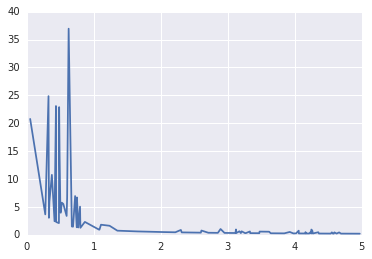

In [308]:
merged = pd.merge(crimes_count_fp, locations, how='inner', on=['Longitude', 'Latitude']).sort_values(['Dist'])
xx = merged['Dist'][merged['Dist'] < 5]
yy = merged['count'][merged['Dist'] < 5]
yyt = yy/xx
plt.plot(xx, yyt)

In [303]:
merged_c = pd.merge(crimes, locations, how='inner', on=['Longitude', 'Latitude']).sort_values(['Dist'])
xx_c = merged_c['Dist'][merged_c['Dist'] < 6]

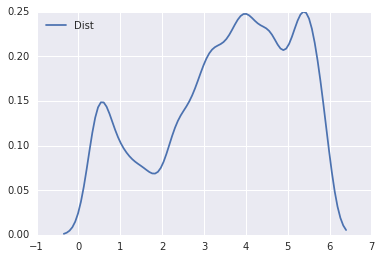

In [304]:
sns.kdeplot(xx_c)

In [299]:
merged_cc = pd.merge(crimes, locations, how='inner', on=['Longitude', 'Latitude']).sort_values(['Dist'])
merged_cc = merged_cc[merged_cc['Dist'] < 2]

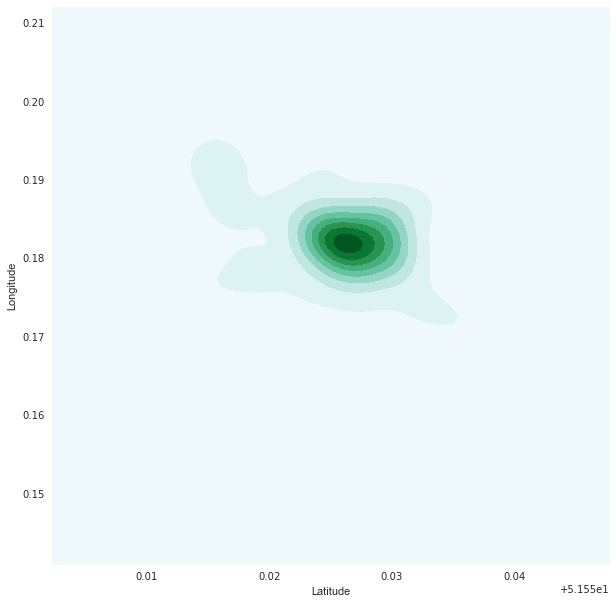

In [301]:
merged_cc = pd.merge(crimes, locations, how='inner', on=['Longitude', 'Latitude']).sort_values(['Dist'])
merged_cc = merged_cc[merged_cc['Dist'] < 2]
f, ax = plt.subplots(figsize=(10, 10))
sns.kdeplot(merged_cc.Latitude, data2=merged_cc.Longitude, shade=True)

In [ ]:
merged_cc = pd.merge(crimes, locations, how='inner', on=['Longitude', 'Latitude']).sort_values(['Dist'])
merged_cc = merged_cc[merged_cc['Dist'] < 2]
f, ax = plt.subplots(figsize=(10, 10))
sns.kdeplot(merged_cc.Latitude, data2=merged_cc.Longitude, shade=True)